# ホールドアウト法と交差検証法
- 線形回帰モデルの汎化誤差を、ホールドアウト法と交差検証法を用いてそれぞれ評価してみよう

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# MAEを計算するための関数
from sklearn.metrics import mean_absolute_error 
# ホールドアウト法を実行するための関数
from sklearn.model_selection import train_test_split 
# 交差検証法を実行するための関数
from sklearn.model_selection import KFold, cross_val_score, cross_validate

# dict型の変数を綺麗にprintするための関数
from pprint import pprint

## 2. データの読み込み 

In [2]:
# CSVファイルの読み込み
df_diamond = pd.read_csv("../../1_data/ch4/diamond_data.csv")

# ダイヤモンドの重さの単位であるカラットとその価格に関する実際のデータ
#『回帰分析入門』より引用
display(df_diamond.head())
df_diamond.describe()

,carat,price
0,0.30,1302
1,0.30,1510
2,0.30,1510
3,0.30,1260
4,0.31,1641


,carat,price
count,308.000000,308.000000
mean,0.630909,5019.483766
std,0.277183,3403.115715
min,0.180000,638.000000
25%,0.350000,1625.000000
50%,0.620000,4215.000000
75%,0.850000,7446.000000
max,1.100000,16008.000000


## 3. データの可視化

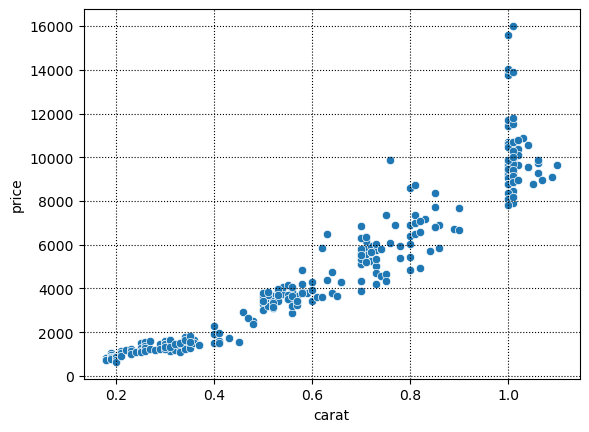

In [3]:
# データのプロット
# 正解データ作成
x = df_diamond["carat"].values
# 学習用データ作成
y = df_diamond["price"].values

sns.scatterplot(x=x, y=y, marker='o')
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.ylabel('price')
plt.xlabel('carat')
plt.show()

## 4. ホールドアウト法
- データを事前に学習用とテスト用に分割
    - それぞれ訓練用・検証用と呼ぶ場合もある
    - ここでは簡単化のため学習用・テスト用と呼ぶ
- テスト用データで学習済みモデルの汎化誤差を評価する

### 4-1. データの分割

In [4]:
# scikit-learnに入力するために整形
X = x.reshape(-1,1) 

# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.2 

# 学習データとテストデータの分割
# テストデータはランダムに選択される
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

- `X_train` : 学習用データの説明変数
- `X_test` : テスト用データの説明変数
- `y_train` : 学習用データの目的変数
- `y_test` : テスト用データの目的変数

### 4-2. モデルの構築・学習

In [5]:
# 線形回帰モデルの構築
regr = LinearRegression(fit_intercept=True)
# モデルを学習させる
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_pred_train)
print("MAE = %s"%round(mae,3) )

MAE = 707.119


### 4-3. 汎化誤差の評価

In [6]:
# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

MAE = 855.624


### 4-4. 予測結果の可視化

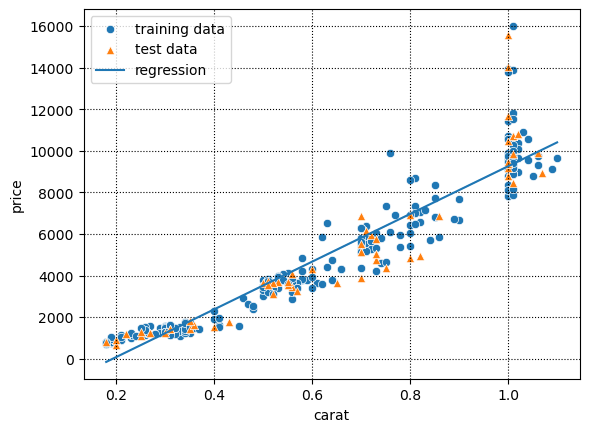

In [7]:
# データの散布図を表示
# X_train, X_test は2次元配列なので、1次元の配列へ変換
sns.scatterplot(x=np.ravel(X_train), y=y_train, marker='o', label='training data')
sns.scatterplot(x=np.ravel(X_test), y=y_test, marker='^', label='test data')

# 軸ラベルの設定
plt.ylabel("price")
plt.xlabel("carat")

# グリッド線の表示
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

# 回帰直線の表示
sns.lineplot(x=np.ravel(X_train), y=y_pred_train, label='regression')

# 凡例の表示位置を調整
plt.legend(loc='best')
plt.show()

## 5. 交差検証法
- データを複数のグループに分ける
- 1つのグループをテスト用、それ以外を学習用とする
- テスト用と学習用を交代させてながら、汎化誤差を評価する
- 実装方法
    - [KFold()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)のみを用いる
    - KFold()と[cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)を用いる
    - KFold()と[cross_validate()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)を用いる

### 5-1. KFold() のみを用いる場合
- KFoldクラスのインスタンスを作成
    - split()メソッドを用いて学習用、テスト用のデータの番号（インデックス）を取得
    - そのインデックスを用いてX, yからデータを抽出し、学習用データ・テスト用データとする

In [8]:
X = x.reshape(-1,1) # scikit-learnに入力するために整形
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# K-Foldクロスバリデーションの定義
kf = KFold(n_splits=n_split, shuffle=True, random_state=1234)

# テスト役を交代させながら学習と評価を繰り返す
# KFoldオブジェクトから取り出せる値は、インデックスの集まり
for train_idx, test_idx in kf.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    # モデルを学習させる
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3), end="\n\n")
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を計算し、最終的な汎化誤差の値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 855.624

Fold 2
MAE = 663.313

Fold 3
MAE = 555.675

Fold 4
MAE = 803.69

Fold 5
MAE = 874.072

Cross Validation MAE = 750.475


### 5-2. cross_val_score()を用いる場合
- 引数scoringには、計算したい評価指標を指定する
- [指定できる評価指標の一覧](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [9]:
from sklearn.model_selection import cross_val_score

# モデルを定義
model = LinearRegression()

# 5-fold cross-validationを実行し、MAEを計算
# scoringで二乗誤差を選択
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# スコアは符号反転させたMAEなので、-1を掛けて通常のMAEに戻す
mae_scores = -scores

print('Cross-validation MAE: {}'.format(mae_scores))
print('Average cross-validation MAE: {}'.format(mae_scores.mean()))

Cross-validation MAE: [855.62377818 663.31306948 555.67508545 803.68954335 874.07185185]
Average cross-validation MAE: 750.4746656623304


### 5-3. cross_validate()を用いる場合
- cross_val_score()との違い
    - 返り値scoresがdict型の変数となっている
    - scoringに複数の[評価指標](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)を指定できる（list, dictで指定）
    - return_estimator=Trueと設定しておくと、各Foldにおける学習済みモデルを取り出せる

In [10]:
# scoringにMAEとRMSEを設定
scoring = {"mae":"neg_mean_absolute_error", 
           "rmse":"neg_root_mean_squared_error"}

# 5-fold cross-validationを実行し、評価指標を計算
scores = cross_validate(regr, X, y, cv=kf, scoring=scoring,
                       return_estimator=True)

# scoresはdict型の変数になっている
pprint(scores)

# スコアは符号反転させたものなので、-1を掛けて通常の指標に戻す
mae_array = scores['test_mae']*-1
print("MAE = %s"%np.round(mae_array, 3))
rmse_array = scores['test_rmse']*-1
print("RMSE = %s"%np.round(rmse_array, 3))

# 評価指標の平均値を計算し、最終的な汎化誤差の値とする
final_mae_ = mae_array.mean()
print("Cross Validation MAE = %s"%round(final_mae_, 3))
final_rmse_ = rmse_array.mean()
print("Cross Validation RMSE = %s"%round(final_rmse_, 3))

{'estimator': [LinearRegression(),
               LinearRegression(),
               LinearRegression(),
               LinearRegression(),
               LinearRegression()],
 'fit_time': array([0.00200105, 0.00100088, 0.00100064, 0.00099897, 0.00099874]),
 'score_time': array([0.00099945, 0.00199771, 0.00100064, 0.0010016 , 0.00100136]),
 'test_mae': array([-855.62377818, -663.31306948, -555.67508545, -803.68954335,
       -874.07185185]),
 'test_rmse': array([-1358.85819781,  -814.03785238,  -718.08808711, -1303.92266334,
       -1286.04938875])}
MAE = [855.624 663.313 555.675 803.69  874.072]
RMSE = [1358.858  814.038  718.088 1303.923 1286.049]
Cross Validation MAE = 750.475
Cross Validation RMSE = 1096.191
